In [1]:
%matplotlib inline
%load_ext Cython

import matplotlib.pyplot as plt
import numpy as np

import lux
import pandas as pd
import pyarrow as pa
from pyarrow import csv
import time

from tqdm import tqdm
from scipy.special import erfc

from scipy.optimize import curve_fit
from scipy import stats
from scipy.special import gamma
from scipy.misc import derivative

import boost_histogram as bh

from nicks_plot_utils import *


import warnings
warnings.filterwarnings('ignore')


from lmfit.models import *
from lmfit import Model

import inspect

COLOR_BLUE='#348ABD'
COLOR_RED='#A60628'



In [2]:
%%cython --annotate
import numpy as np
cimport numpy as np
from libc.math cimport sin, cos, sqrt
from scipy import stats
cimport cython

cdef float MP = 0.93827208816
cdef float E0 = 4.81726
#cdef float E0 = 4.8056
cdef float ME = 0.00051099895

cdef float p_targ_px = 0.0
cdef float p_targ_py = 0.0
cdef float p_targ_pz = 0.0
cdef float p_targ_E = MP

cdef float e_beam_px = 0.0
cdef float e_beam_py = 0.0
cdef float e_beam_pz = sqrt(E0**2-ME**2)
cdef float e_beam_E = E0

# @np.vectorize
# def calc_W(float e_p, float e_theta, float e_phi):
#     cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
#     cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
#     cdef float e_prime_pz = e_p*cos(e_theta)
#     cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
#     cdef float temp_px = e_beam_px - e_prime_px + p_targ_px
#     cdef float temp_py = e_beam_py - e_prime_py + p_targ_py
#     cdef float temp_pz = e_beam_pz - e_prime_pz + p_targ_pz
#     cdef float temp_E = e_beam_E - e_prime_E + p_targ_E
    
    
#     cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2
#     cdef float temp3 = sqrt(-temp2)
    
    
#     return temp3

# @np.vectorize
# def calc_q2(float e_p, float e_theta, float e_phi):
#     cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
#     cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
#     cdef float e_prime_pz = e_p*cos(e_theta)
#     cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
#     cdef float temp_px = e_beam_px - e_prime_px
#     cdef float temp_py = e_beam_py - e_prime_py
#     cdef float temp_pz = e_beam_pz - e_prime_pz
#     cdef float temp_E = e_beam_E - e_prime_E

#     cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2

#     return temp2

@np.vectorize
def calc_wq2(float e_p, float e_theta, float e_phi):
    cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    cdef float e_prime_pz = e_p*cos(e_theta)
    cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px
    cdef float temp_py = e_beam_py - e_prime_py
    cdef float temp_pz = e_beam_pz - e_prime_pz
    cdef float temp_E = e_beam_E - e_prime_E

    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2
    cdef float q2 = temp2
    
    temp_px += p_targ_px
    temp_py += p_targ_py
    temp_pz += p_targ_pz
    temp_E += p_targ_E
    
    temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2
    cdef float w = sqrt(-temp2)
    
    return w, q2


In [3]:
#all_data = pd.read_csv("/Users/tylern/Data/fid_cuts.csv")

pyTable = csv.read_csv(
        "/Users/tylern/Data/fid_cuts.csv",
        read_options=csv.ReadOptions(use_threads=True)
)
all_data = pyTable.to_pandas(strings_to_categorical=True)

In [4]:
%time all_data['w'], all_data['q2'] = calc_wq2(all_data.e_p,all_data.e_theta,all_data.e_phi)

all_data.head()

CPU times: user 860 ms, sys: 270 ms, total: 1.13 s
Wall time: 1.13 s


,sector,e_p,e_theta,e_phi,theta,phi,x,y,type,w,q2
0,2,0.745735,0.857864,0.653292,0.857864,0.653292,218.023438,-25.849747,elastic,2.456666,2.485544
1,6,0.607603,0.714833,2.943370,0.714833,2.943371,137.769119,-30.667089,elastic,2.710522,1.433033
2,4,4.206346,0.237482,-1.651334,0.237482,4.631852,48.914841,7.668604,elastic,0.943044,1.137429
3,5,3.823212,0.273460,-2.782747,0.273460,3.500438,59.408146,14.074598,elastic,1.173469,1.368699
4,4,0.855761,0.535205,-1.483713,0.535205,4.799473,62.425549,-3.625322,elastic,2.676072,1.152924


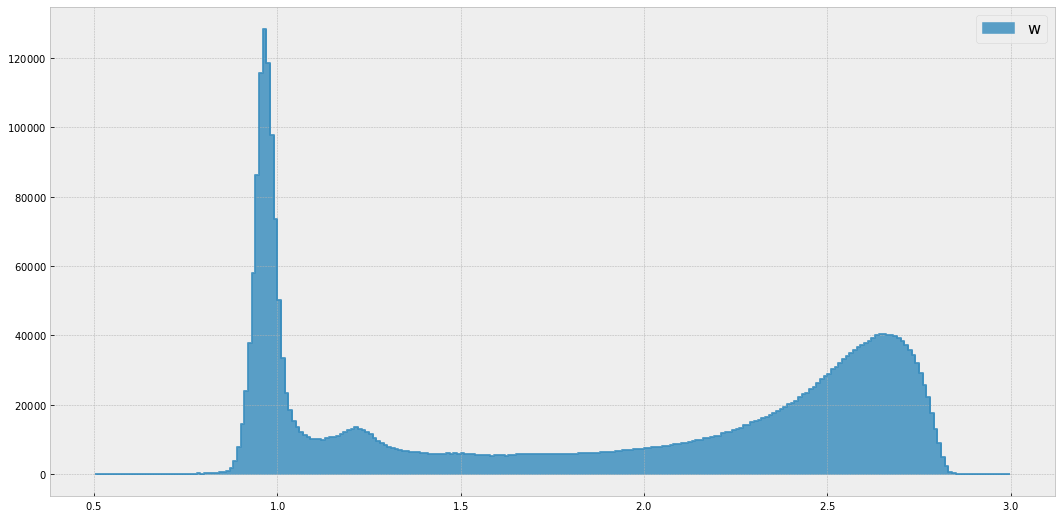

In [5]:
testHist = Hist1D(xrange=[0.5,3.0],bins=250)

testHist.fill(all_data.w[all_data.type == "elastic"])

fig, ax = plt.subplots(figsize=[18,9])
testHist.histogram(filled=True, density=False)

fid_data = all_data[all_data.type == "elastic"]


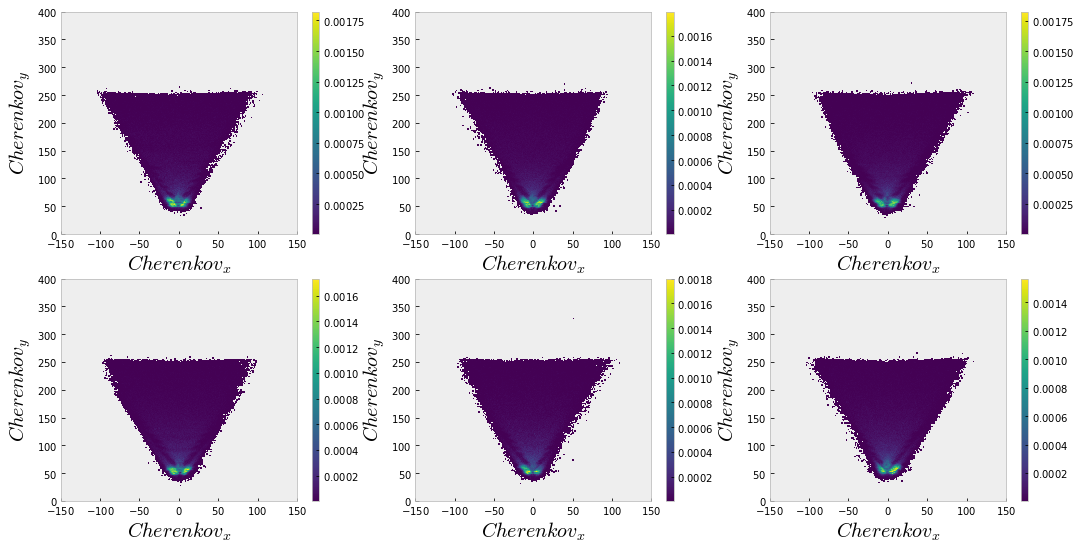

In [6]:

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[18,9])
for sec in range(1,7):
    data = fid_data[(fid_data.sector == sec) & (fid_data.type == "elastic")]
    hist = Hist2D(data.y, data.x, xbins=500, xrange=[-150, 150], xname="$Cherenkov_x$", ybins=500, yrange=[0, 400], yname="$Cherenkov_y$")
    hist.plot(ax[sec%2,sec%3], zeros=False)

    fig.show()



Number = 313,768
Number = 143,265
Number = 399,541
Number = 244,325
Number = 375,229
Number = 231,597
Number = 349,261
Number = 229,988
Number = 420,379
Number = 192,270
Number = 304,194
Number = 170,292


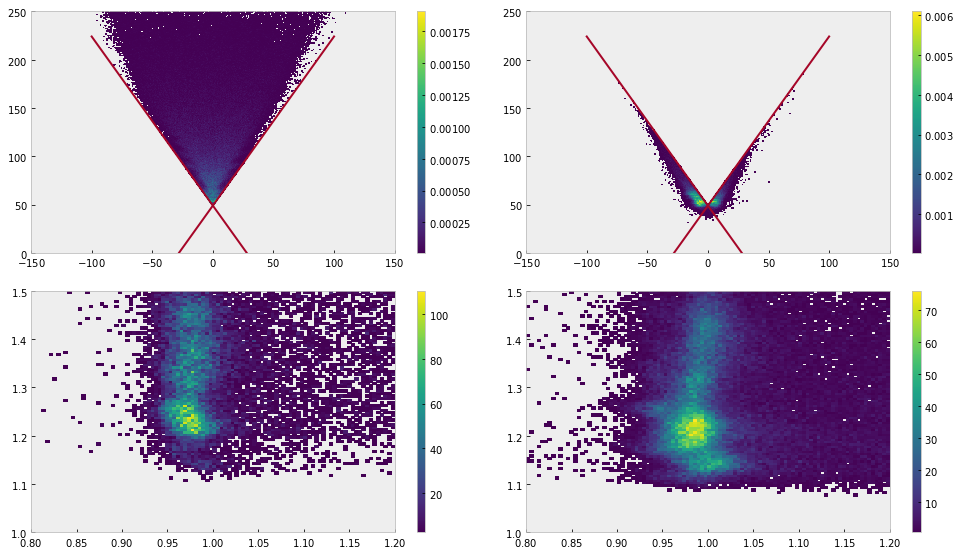

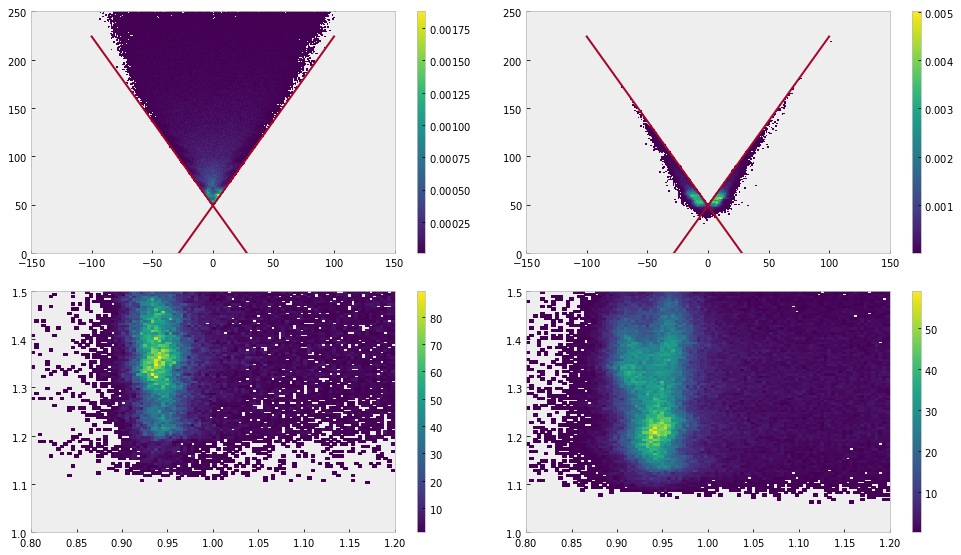

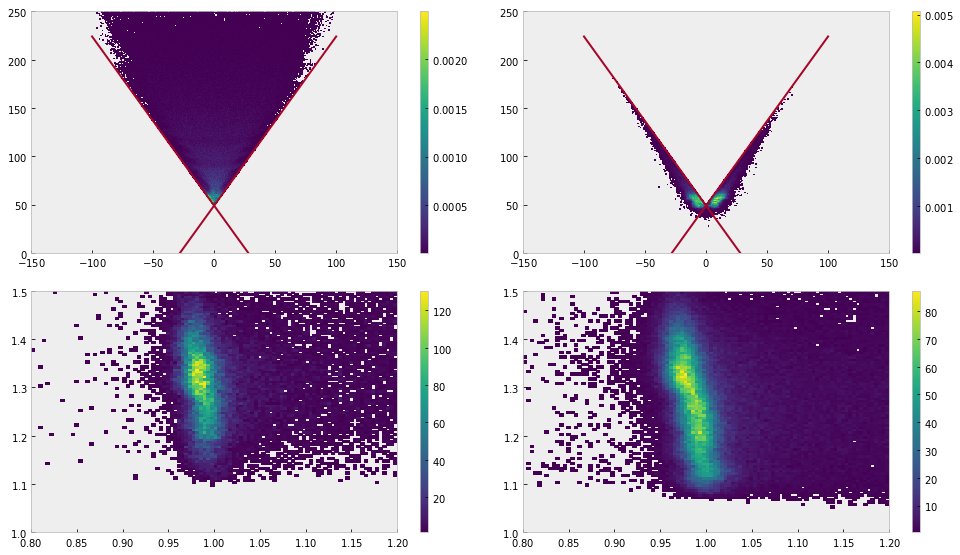

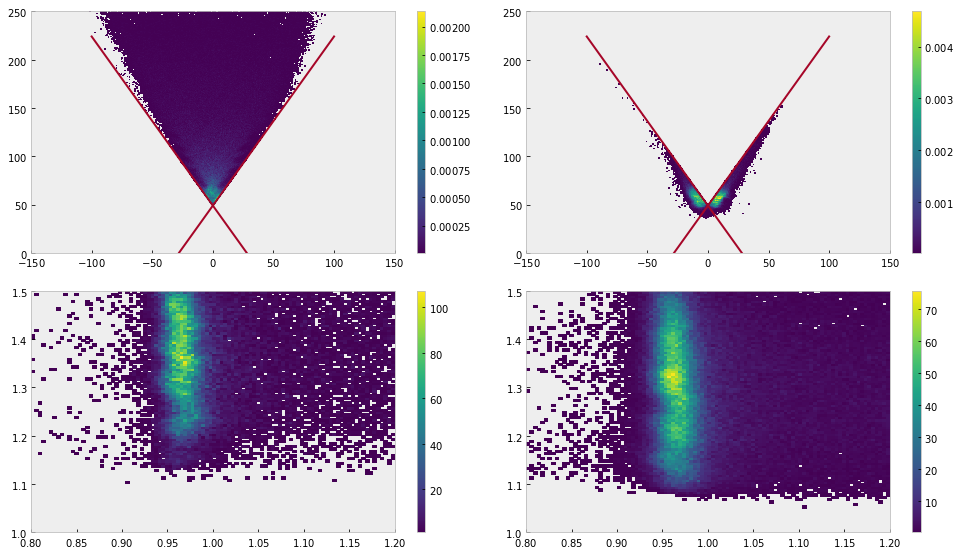

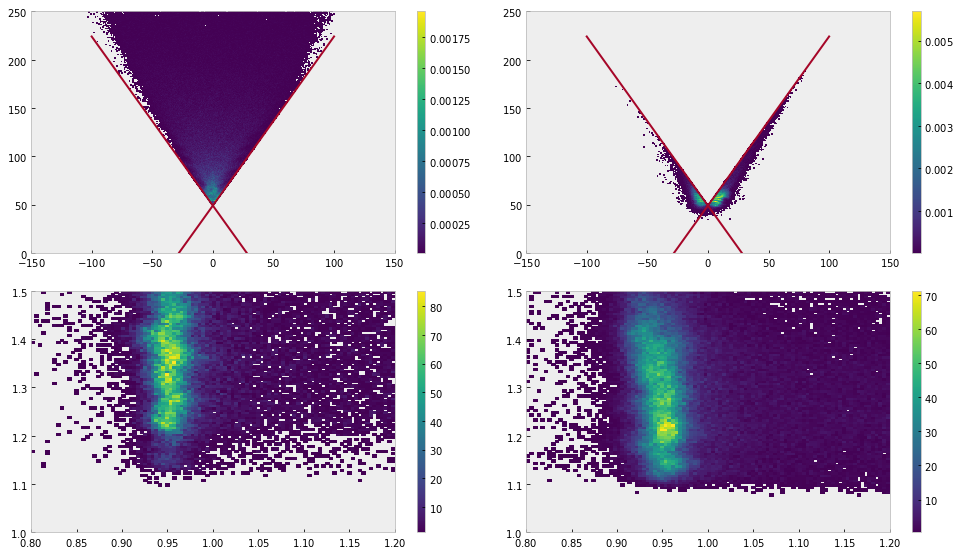

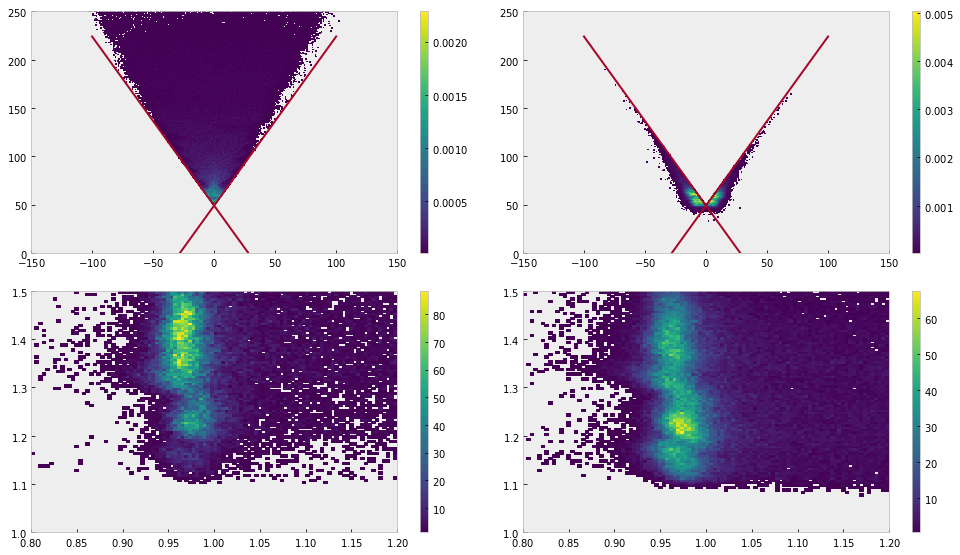

In [7]:
slope = 1.75
intercept = 49

def line(xs, slope, intercept):
    return slope*xs + intercept

for sec in range(1,7):
    cuts = (fid_data[fid_data.sector == sec].x > line(fid_data[fid_data.sector == sec].y, -slope, intercept)) \
            & (fid_data[fid_data.sector == sec].x > line(fid_data[fid_data.sector == sec].y, slope, intercept))

    fig, ax = plt.subplots(nrows=2, ncols=2,figsize=[14,8])
    for i, cut_mask in enumerate([cuts, ~cuts]):
        do_cuts = (cut_mask) & (fid_data.type == "elastic") & (fid_data.sector == sec)
        hist = bh.Histogram(
                bh.axis.Regular(500, -150, 150, metadata="$CC_x$"), 
                bh.axis.Regular(500, 0, 250, metadata="$CC_y$")
            )

        hist.fill(fid_data[do_cuts].y, fid_data[do_cuts].x)
        Hist2D(boost_hist=hist).plot(ax[0,i], zeros=False)
        xs = np.linspace(-50,100, 250)
        ax[0, i].set_ylim(0, 250)
        ax[0, i].plot(xs,line(xs, slope, intercept), c=COLOR_RED)
        ax[0, i].plot(-xs,line(-xs, -slope, intercept), c=COLOR_RED)
        #plt.show()

        #fig, ax = plt.subplots(figsize=[18,9])
        hist = bh.Histogram(
                bh.axis.Regular(100, 0.8, 1.2, metadata="$W~[Gev]$"), 
                bh.axis.Regular(100, 1.0, 1.5, metadata="$Q^2~[GeV^2]$")
            )

        hist.fill(fid_data[do_cuts].w, fid_data[do_cuts].q2)
        Hist2D(boost_hist=hist).plot(ax[1,i], zeros=False)
        
        print(f'Number = {fid_data[do_cuts].w.to_numpy().shape[0]:,}')


    plt.tight_layout()

NameError: name 'plot2D' is not defined

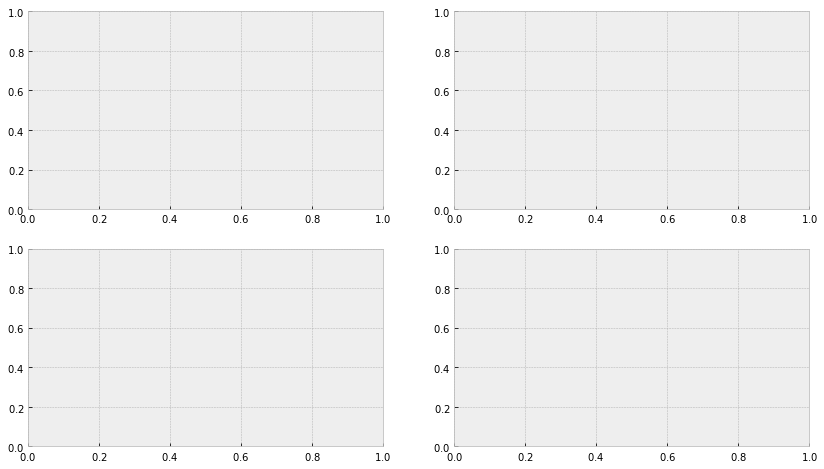

In [10]:
slope = 1.75
intercept = 49

def line(xs, slope, intercept):
    return slope*xs + intercept

cuts = (fid_data.x > line(fid_data.y, -slope, intercept)) & (fid_data.x > line(fid_data.y, slope, intercept))

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=[14,8])
for i, cut_mask in enumerate([cuts, ~cuts]):
    do_cuts = (cut_mask) & (fid_data.type == "channel")
    hist = bh.Histogram(
            bh.axis.Regular(500, -150, 150, metadata="$CC_x$"), 
            bh.axis.Regular(500, 0, 250, metadata="$CC_y$")
        )

    hist.fill(fid_data[do_cuts].y, fid_data[do_cuts].x)
    plot2D(ax[0,i],hist)
    xs = np.linspace(-50, 120, 250)
    ax[0, i].set_ylim(0, 250)
    ax[0, i].plot(xs,line(xs, slope, intercept), c=COLOR_RED)
    ax[0, i].plot(-xs,line(-xs, -slope, intercept), c=COLOR_RED)
    #plt.show()

    #fig, ax = plt.subplots(figsize=[18,9])
    hist = bh.Histogram(
            bh.axis.Regular(80, 1.2, 1.8, metadata="$W~[Gev]$"), 
            bh.axis.Regular(80, 1.0, 2.0, metadata="$Q^2~[GeV^2]$")
        )

    hist.fill(fid_data[do_cuts].w, fid_data[do_cuts].q2)
    plot2D(ax[1,i],hist)
    print(f'Number = {fid_data[do_cuts].w.to_numpy().shape[0]:,}')
    # ax[1, i].legend([f'Number = {fid_data[do_cuts].w.to_numpy().shape[0]:,}'])

plt.tight_layout()

NameError: name 'plot2D' is not defined

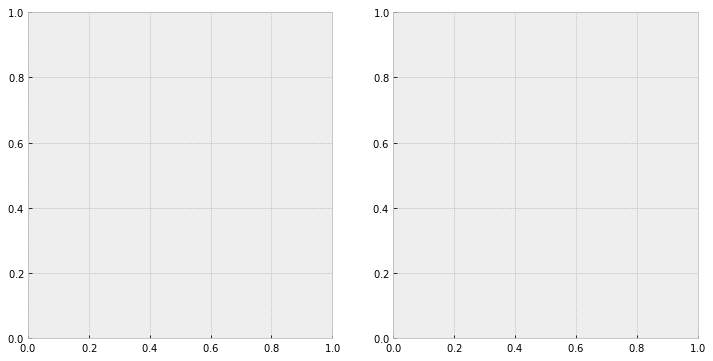

In [12]:
slope = 1.75
intercept = 49

def cut(xs, slope, intercept):
    return slope*xs + intercept

cuts = (fid_data.x > cut(fid_data.y, -slope, intercept)) & (fid_data.x > cut(fid_data.y, slope, intercept))

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=[12, 6])
for i, cut_mask in enumerate([cuts, ~cuts]):
    do_cuts = (cut_mask) & (fid_data.type == "other")
    hist = bh.Histogram(
            bh.axis.Regular(500, -150, 150, metadata="$CC_x [cm]$"), 
            bh.axis.Regular(500, 0, 250, metadata="$CC_y [cm]$")
        )

    hist.fill(fid_data[do_cuts].y, fid_data[do_cuts].x)
    plot2D(ax[i],hist)
    xs = np.linspace(-50,120, 250)
    ax[i].set_ylim(0, 250)
    ax[i].plot(xs,line(xs, slope, intercept), c=COLOR_RED, lw=2)
    ax[i].plot(-xs,line(-xs, -slope, intercept), c=COLOR_RED, lw=2)


    print(f'Number = {fid_data[do_cuts].w.to_numpy().shape[0]:,}')
    #ax[1, i].legend([f'Number = {fid_data[do_cuts].w.to_numpy().shape[0]:,}'])

plt.tight_layout()

NameError: name 'plot2D' is not defined

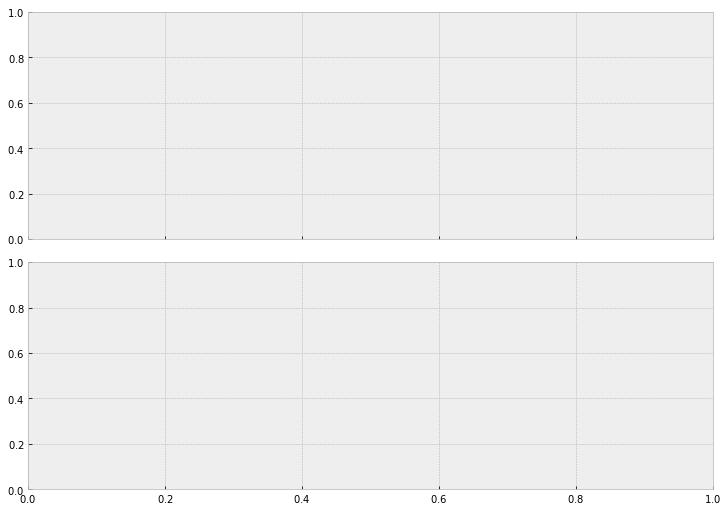

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=[10,7], sharex=True, constrained_layout=True)

hist = bh.Histogram(
            bh.axis.Regular(100, 1.0, 1.85, metadata="$W~[GeV]$"), 
            bh.axis.Regular(100, 1.0, 3.5, metadata="$Q^2~[GeV^2]$")
        )

hist.fill(fid_data[fid_data.type == "PPi0"].w, fid_data[fid_data.type == "PPi0"].q2)

plot2D(ax[0], hist)
plot1D(ax[1], hist.project(0))


fig.suptitle('$W$ vs $Q^2$ for $p\pi^{0}$ events', fontsize=16)
plt.show()

NameError: name 'plot2D' is not defined

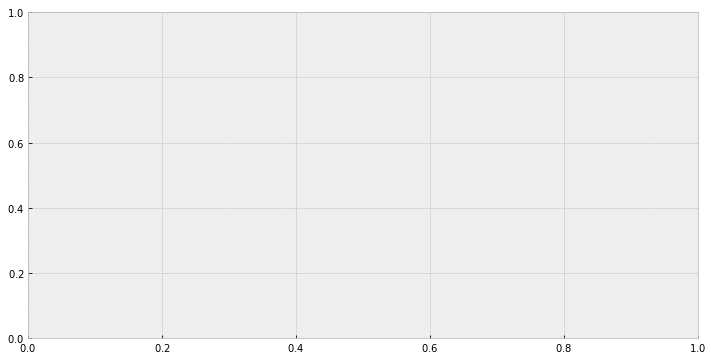

In [14]:
slope = 1.75
intercept = 49

def line(xs, slope, intercept):
    return slope*xs + intercept

cuts = (fid_data.x > cut(fid_data.y, -slope, intercept)) & (fid_data.x > cut(fid_data.y, slope, intercept))

fig, ax = plt.subplots(figsize=[12, 6])

hist = bh.Histogram(
            bh.axis.Regular(1000, -150, 150, metadata="$CC_x [cm]$"), 
            bh.axis.Regular(1000, 0, 250, metadata="$CC_y [cm]$")
    )

hist.fill(fid_data.y, fid_data.x)
plot2D(ax,hist)
xs = np.linspace(-50,120, 250)
ax.set_ylim(0, 250)
ax.plot(xs,line(xs, slope, intercept), c=COLOR_RED, lw=2)
ax.plot(-xs,line(-xs, -slope, intercept), c=COLOR_RED, lw=2)

plt.title("Electron Cherenkov Fiducial Cut")
plt.tight_layout()

NameError: name 'plot2D' is not defined

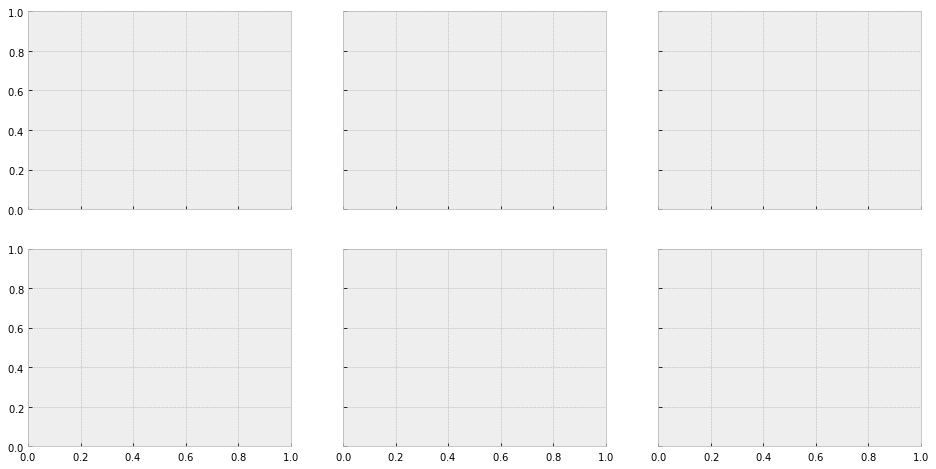

In [15]:
slope = 1.75
intercept = 49

plots = {
        1 : (0,0),
        2 : (0,1),
        3 : (0,2),
        4 : (1,0),
        5 : (1,1),
        6 : (1,2),
       }

def line(xs, slope, intercept):
    return slope*xs + intercept

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[16, 8], sharex=True, sharey=True)
for sec in range(1, 7):
    do_cuts = fid_data.sector == sec
    hist = bh.Histogram(
            bh.axis.Regular(500, -150, 150, metadata="$CC_x [cm]$"), 
            bh.axis.Regular(500, 0, 250, metadata="$CC_y [cm]$")
        )

    hist.fill(fid_data[do_cuts].y, fid_data[do_cuts].x)
    plot2D(ax[plots[sec][0],plots[sec][1]],hist)
    xs = np.linspace(-50,120, 250)
    ax[plots[sec][0],plots[sec][1]].set_ylim(0, 250)
    ax[plots[sec][0],plots[sec][1]].plot(xs,line(xs, slope, intercept), c=COLOR_RED, lw=2)
    ax[plots[sec][0],plots[sec][1]].plot(-xs,line(-xs, -slope, intercept), c=COLOR_RED, lw=2)


    print(f'Number = {fid_data[do_cuts].w.to_numpy().shape[0]:,}')
    #ax[1, i].legend([f'Number = {fid_data[do_cuts].w.to_numpy().shape[0]:,}'])

plt.suptitle("Electron Cherenkov Fiducial Cut Sector by Sector")
plt.tight_layout()